<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 14: Inferencia Bayesiana, ejercicios</span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

## Ejercicio 1

Comparar cómo cambia el posterior al usar un prior informativo, por ejemplo $\rm{Beta}(2,5)$, que favorece valores más pequeños de $p$.

### Instrucciones
1. Usa el mismo $n$ y $x$ del notebook anterior
2. Cambia el prior por el sugerido
3. Grafica y compara el posterior resultante vs el caso no informativo (uniforme)
4. Discute si el prior afecta mucho o poco los resultados cuando $n$ es grande.

In [1]:
# Librerías 

import os

# (opcional, sólo para estar seguros de no arrastrar cosas viejas)
os.environ.pop("PYTENSOR_FLAGS", None)

import pytensor
# Desactivar compilador C/C++
pytensor.config.cxx = ""
pytensor.config.mode = "FAST_COMPILE"  # para que no intente optimizaciones pesadas

import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Configuración opcional
%config InlineBackend.figure_format = 'retina'

rng = np.random.default_rng(42)

In [3]:
# Número de ensayos (n) y probabilidad real (no conocida en la práctica)
n = 80
p_true = 0.30

# Éxitos observados
x = rng.binomial(n=n, p=p_true)

n, p_true, x

(80, 0.3, 27)

In [19]:
with pm.Model() as beta_no_informative:
    
    # Prior no informativo: Beta(1,1) equivale a uniforme en [0,1]
    p = pm.Beta("p", alpha=1, beta=1)
    
    # Verosimilitud: datos observados
    obs = pm.Binomial("obs", n=n, p=p, observed=x)
    
    # Muestreo MCMC con NUTS
    idata1 = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        progressbar=True,
        idata_kwargs={"log_likelihood":True} # Matriz de verosimilitud punto a punto (pesado computacionalmente)
    )

idata1

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [20]:
with pm.Model() as beta_informative:
    
    # Prior informativo
    p = pm.Beta("p", alpha=2, beta=5)
    
    # Verosimilitud: datos observados
    obs = pm.Binomial("obs", n=n, p=p, observed=x)
    
    # Muestreo MCMC con NUTS
    idata2 = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        progressbar=True,
        idata_kwargs={"log_likelihood":True}
    )

idata2

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

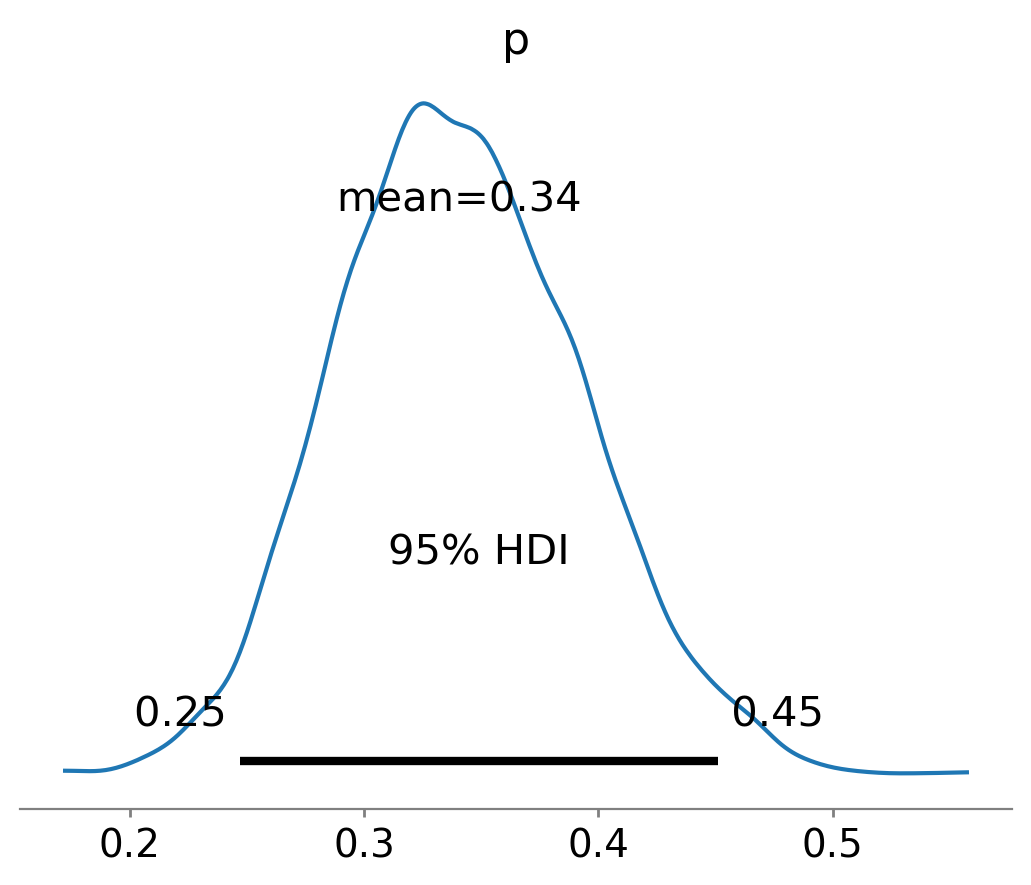

In [21]:
az.plot_posterior(idata1, var_names=["p"], hdi_prob=0.95)
plt.show()

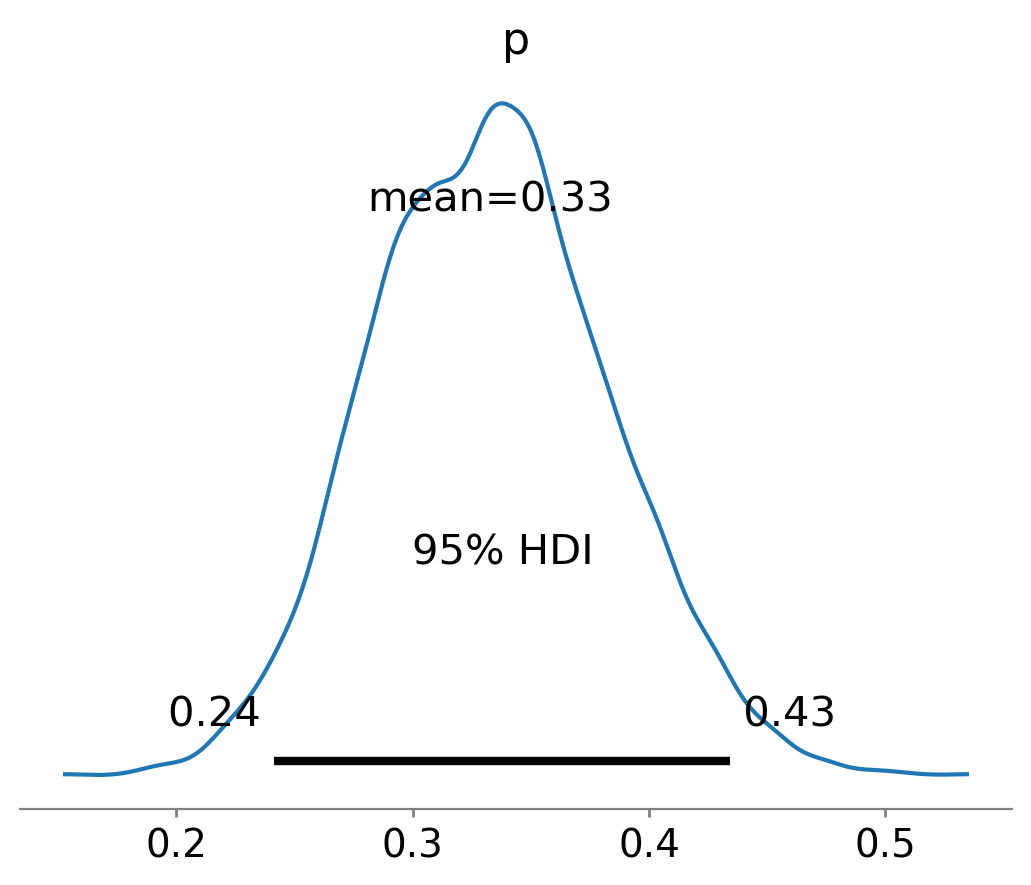

In [22]:
az.plot_posterior(idata2, var_names=["p"], hdi_prob=0.95)
plt.show()

## Ejercicio 2. Chequeo predictivo posterior (PPC)

Evaluar si el modelo reproduce plausiblemente los datos observados.

### Preguntas
* ¿El valor observado $x$ cae en la zona de alta densidad del PPC?
* ¿Qué nos dice si no cae ahí?

Sampling: [obs]


Output()

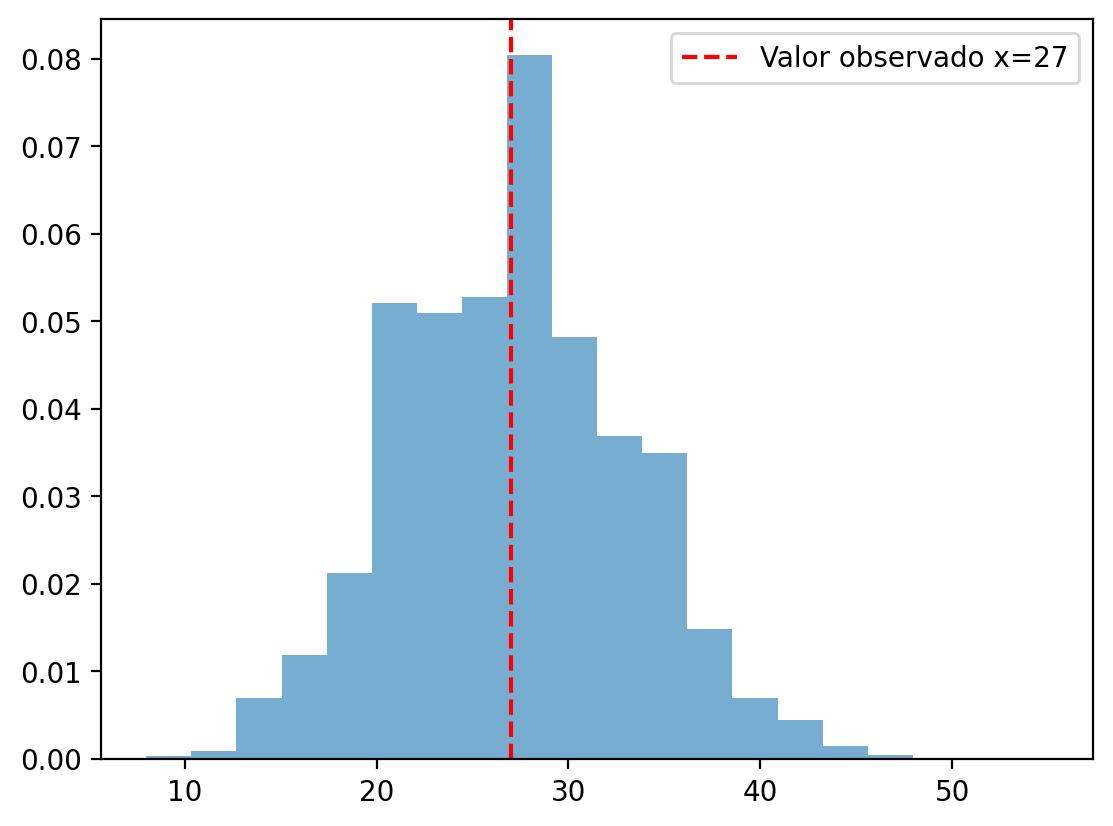

In [23]:
with beta_no_informative:
    ppc_inf = pm.sample_posterior_predictive(idata1, var_names=["obs"], random_seed=123)

x_rep_inf = ppc_inf.posterior_predictive["obs"].values.ravel()

plt.hist(x_rep_inf, bins=20, density=True, alpha=0.6)
plt.axvline(x, color="red", linestyle="--", label=f"Valor observado x={x}")
plt.legend()
plt.show()

Sampling: [obs]


Output()

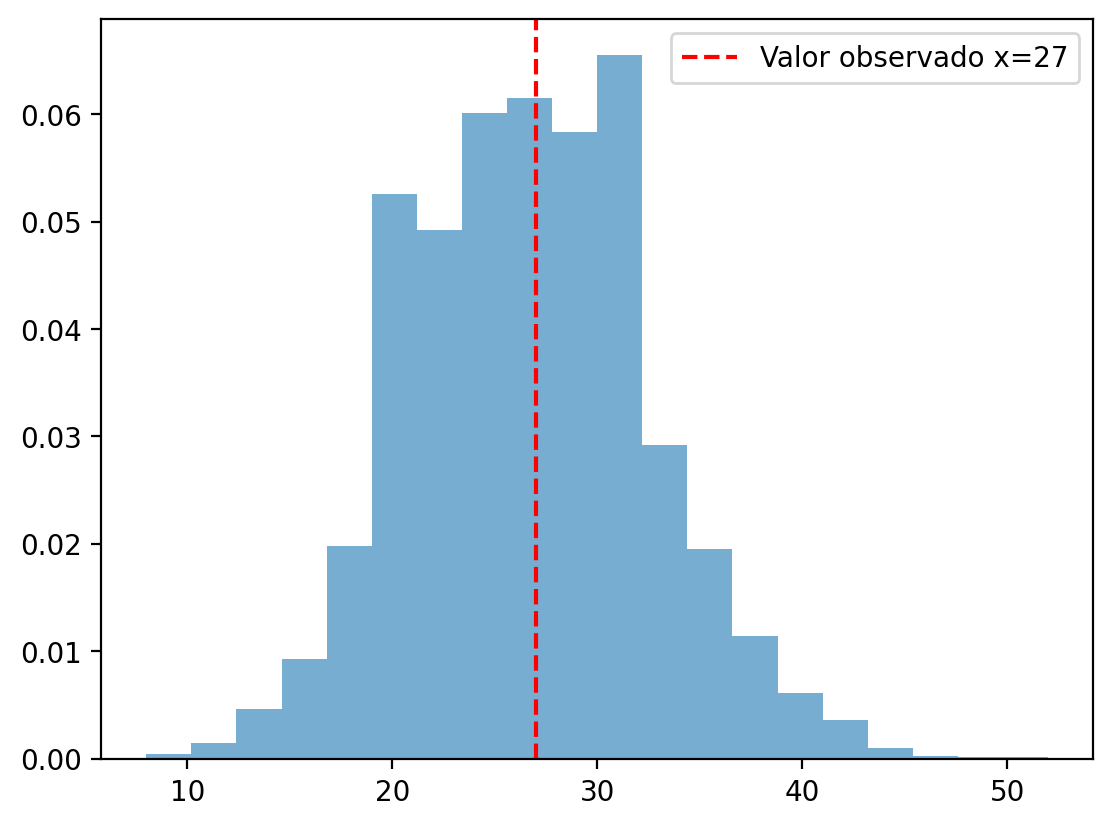

In [24]:
with beta_informative:
    ppc_inf = pm.sample_posterior_predictive(idata2, var_names=["obs"], random_seed=123)

x_rep_inf = ppc_inf.posterior_predictive["obs"].values.ravel()

plt.hist(x_rep_inf, bins=20, density=True, alpha=0.6)
plt.axvline(x, color="red", linestyle="--", label=f"Valor observado x={x}")
plt.legend()
plt.show()

## Ejercicio 3. Regresión lineal con outliers usando una distribución Student t

Vamos a comparar un modelos con errores normales, y un modelo con errores Student-t (más robusto a outliers)

### Instrucciones 
1. Genera datos sintéticos con algunos outliers
2. Ajusta un modelo bayesiano con verosimilitud normal
3. Ajusto otro modelo con verosimilitud Student t
4. Compara lo siguiente,
   * traceplots
   * posterior de la pendiente
   * compatibilidad predictiva

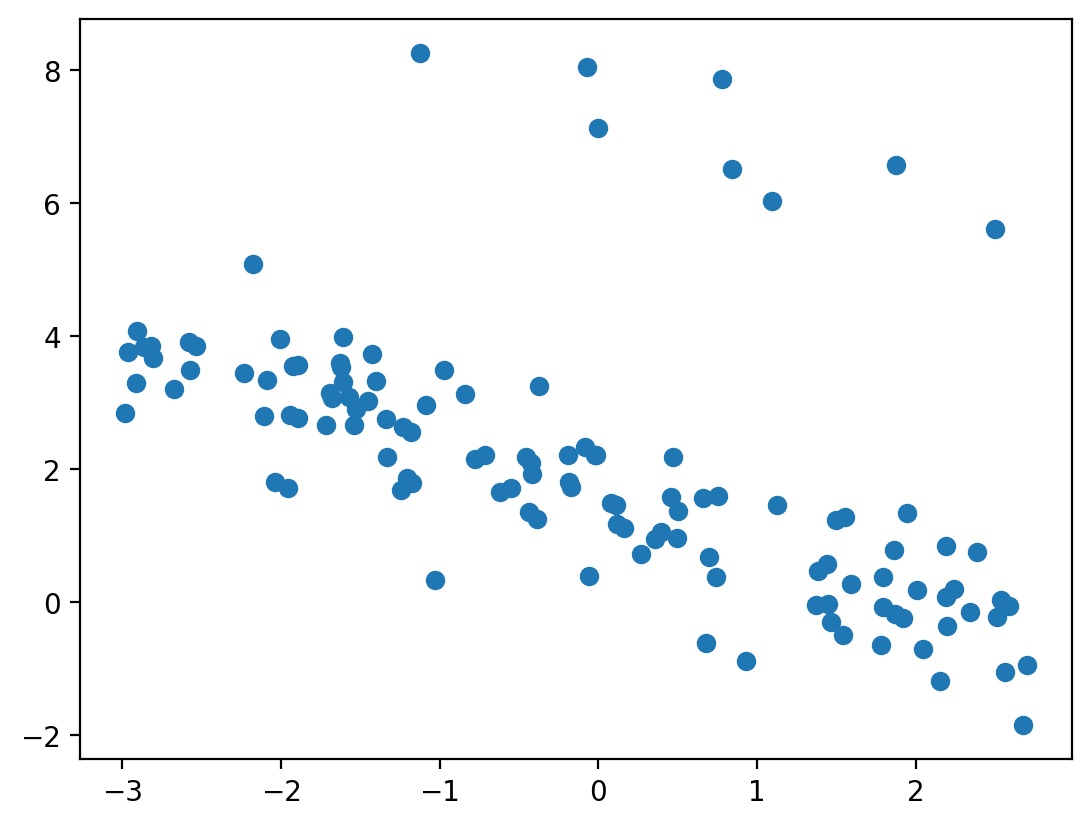

In [25]:
# Generar datos con outliers
rng = np.random.default_rng(123)
x_data = rng.uniform(-3, 3, 120)
y_data = 1.5 - 0.8 * x_data + rng.normal(0, 0.7, size=120)

# Insertar outliers artificiales
y_data[::15] += 6   # cada 15 puntos, agregar un outlier grande

plt.scatter(x_data, y_data)
plt.show()

In [27]:
# Modelo normal
with pm.Model() as linear_normal:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 10)
    sigma = pm.HalfNormal("sigma", 1)

    mu = alpha + beta * x_data
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)

    idata_normal = pm.sample(2000, tune=1000, target_accept=0.9, idata_kwargs={"log_likelihood":True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in power
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [29]:
# Modelo Student t
with pm.Model() as linear_t:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 10)
    sigma = pm.HalfNormal("sigma", 1)
    nu = pm.Exponential("nu", 1)  # grados de libertad

    mu = alpha + beta * x_data
    y_obs = pm.StudentT("y_obs", mu=mu, sigma=sigma, nu=nu, observed=y_data)

    idata_t = pm.sample(2000, tune=1000, target_accept=0.9, idata_kwargs={"log_likelihood":True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


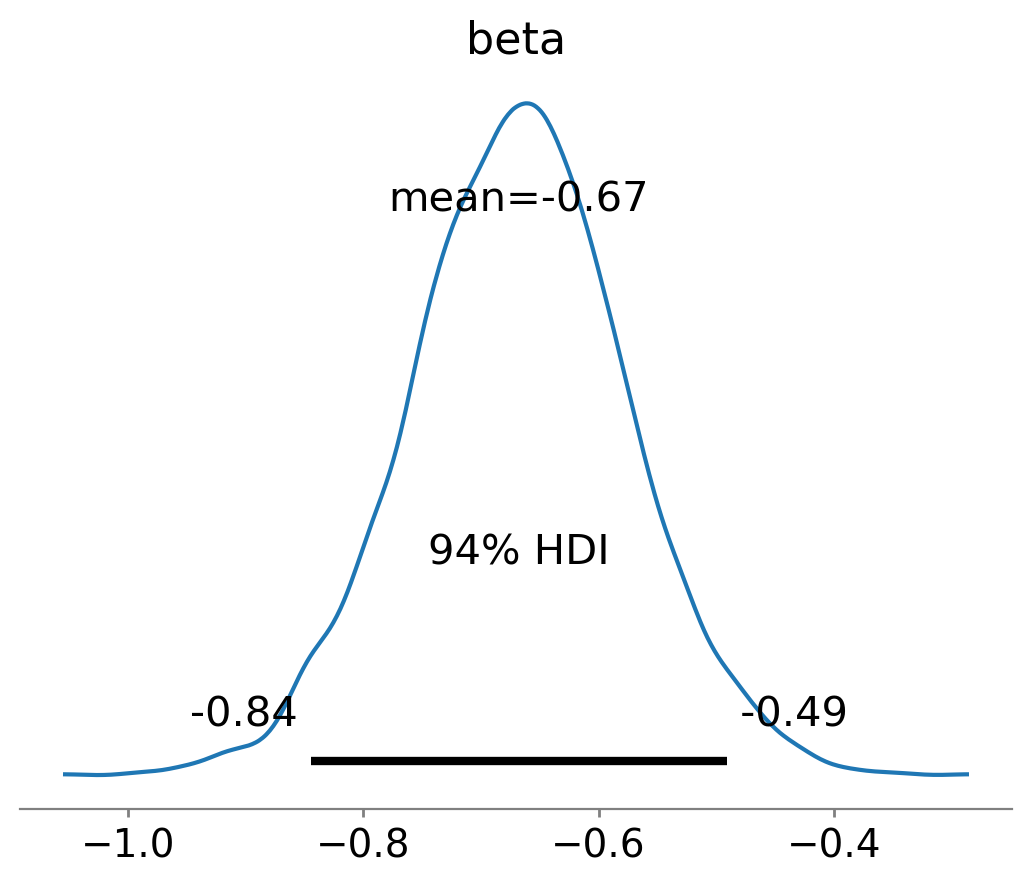

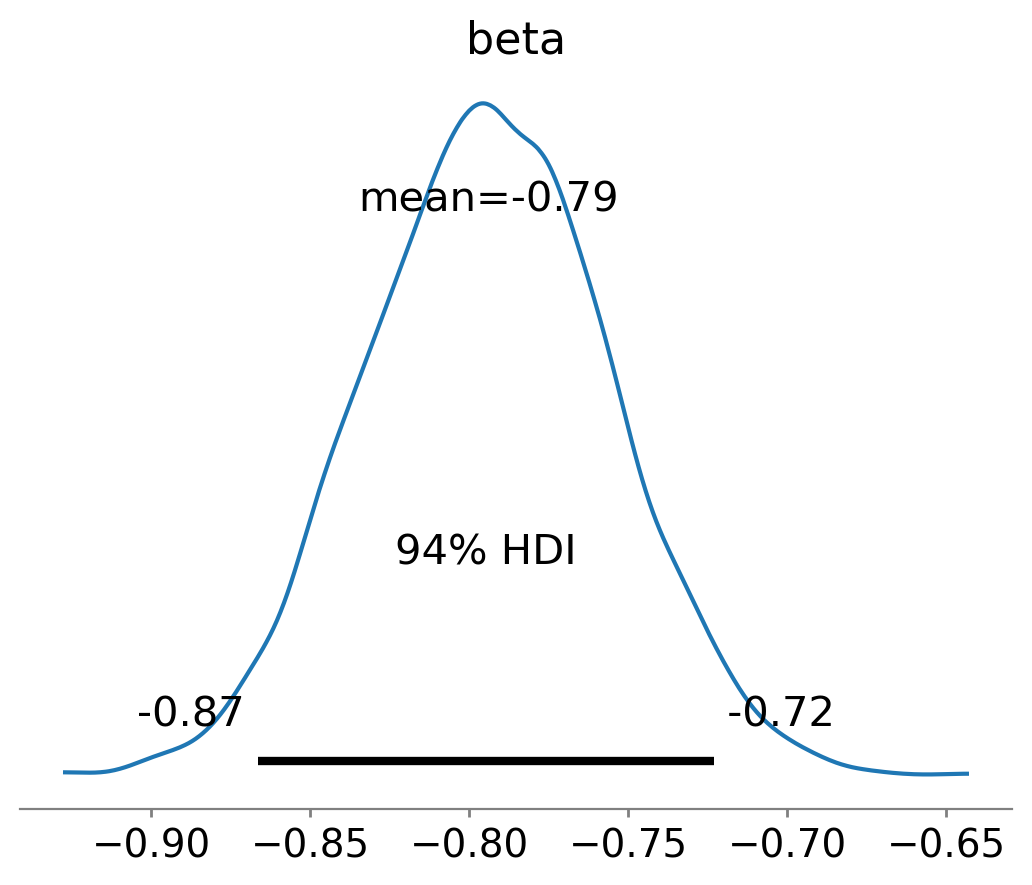

In [31]:
az.plot_posterior(idata_normal, var_names=["beta"])
az.plot_posterior(idata_t, var_names=["beta"])
plt.show()

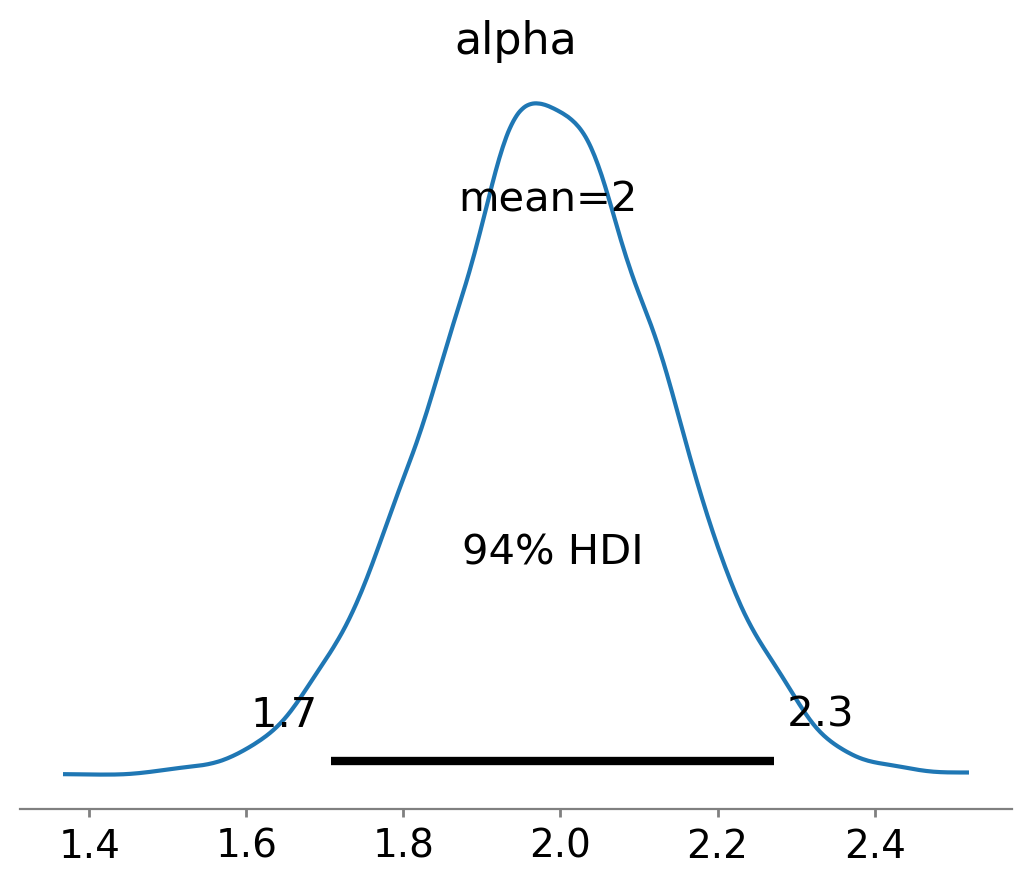

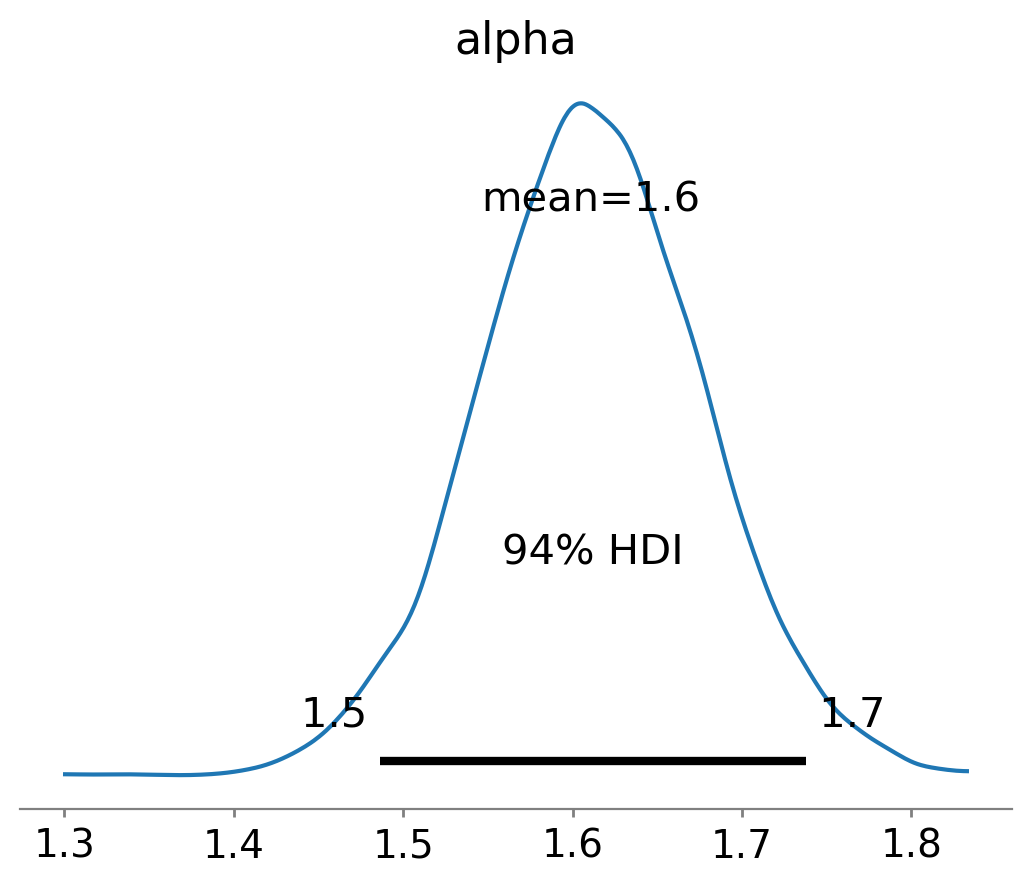

In [32]:
az.plot_posterior(idata_normal, var_names=["alpha"])
az.plot_posterior(idata_t, var_names=["alpha"])
plt.show()

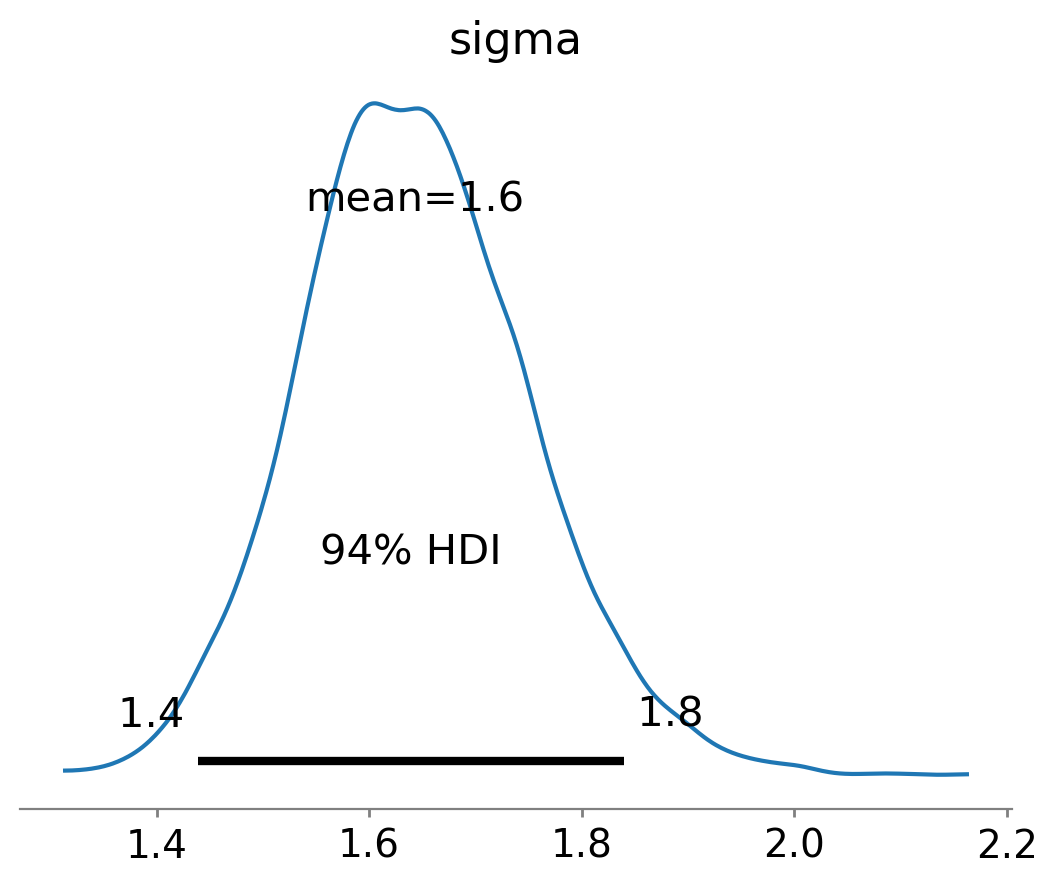

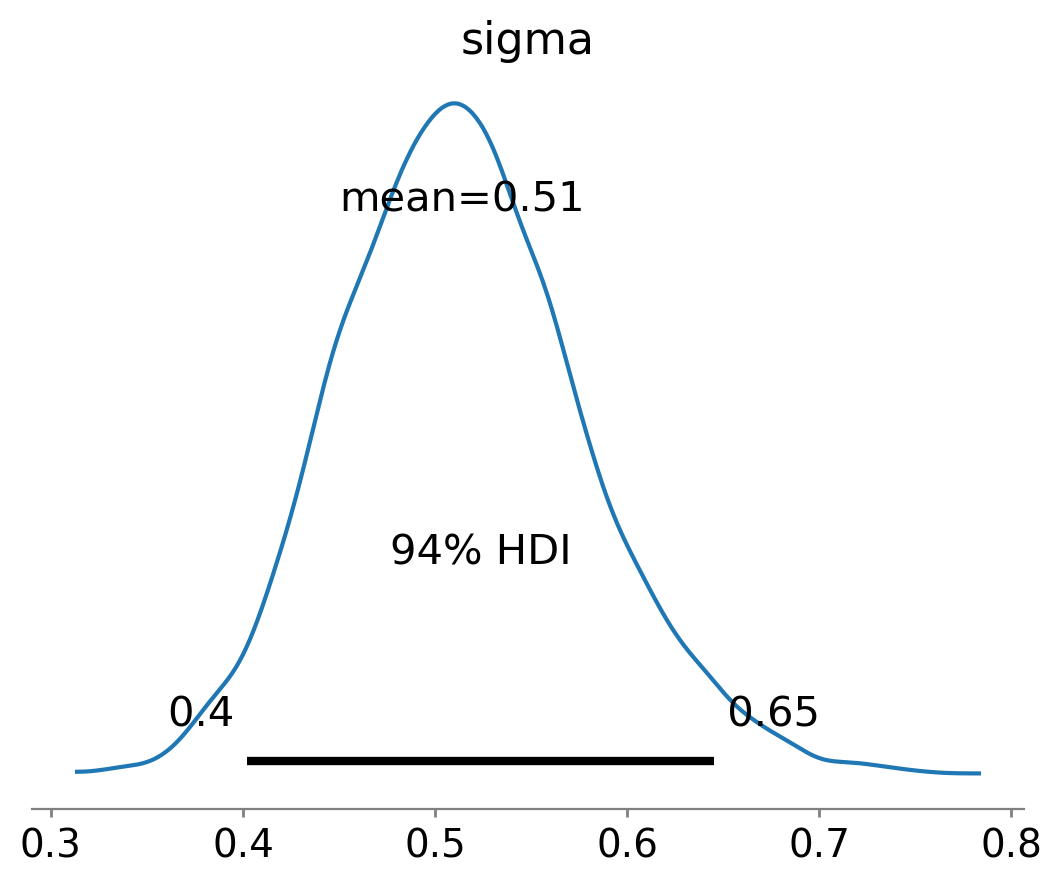

In [33]:
az.plot_posterior(idata_normal, var_names=["sigma"])
az.plot_posterior(idata_t, var_names=["sigma"])
plt.show()

Una distribución Half-Normal es una distribución derivada de una normal estándar, pero solo permite valroes positivos. Formalmente es así,

\begin{equation}
Z \sim \mathcal{N}(0,\sigma)
\end{equation}

pero con $X = |Z| \sim \rm{HalfNormal}(\sigma)$

Es decir, sigue centrada en 0 pero recortas la parte negativa, reflejando sus valroes hacia la región positiva. Cuando modelamos parámetros que solo pueden ser valores positivos, esta distribución puede ser adecuada. Algunos ejemplos de estos parámetros podrían ser varianzas, desviaciones estándar, parámetros de escala, o algunos hiperparámetros de modelos.

En un modelo de regresión lineal clásico (frecuentista o bayesiano), normalmente se asume que los residuos siguen una distribución normal $\varepsilon \sim \mathcal{N}(0,\sigma)$. Esta suposición es conveniente, pero muy frágil. Un solo outlier podría influir fuertemente en la estimación de los parámetros. 

La distribución normal tiene unas colas ligeras, por lo que si aparece un residuo muy grande (outlier), la verosimilitud normal lo "castiga" fuertemente. Entonces, para maximizar la verosimilitud, el modelo tiende a ajustar la recta para redicir ese errror grande. El resultado es que puedes tener pendientes y parámetros beta un poco distorsionados, una sigma inflada o intervalos de confianza más amplios. Los outliers "arrastran" la regresión.

En contraste, una distribución Student t tiene colas más gruesas, por lo que se penaliza menos a estos outliers, y un residuo grande no produce una caída enorme en la versimilitud. Como el punto podría venir de la misma distribución, el modelo no deformaría toda la recta solo para este punto. Esto hace que la inferencia de la pendiente y el intercepto se vuelva más sólida.

## Ejercicio 4. Comparación bayesiana de modelos con LOO (Leave One Out)

Vamos a comparar los modelos usando LOO-CV bayesiano. La librería `arviz` ofrece esta opción.

In [34]:
comparison = az.compare(
    {"Normal": idata1, "StudentT": idata2},
    ic="loo"
)

comparison

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/arviz/stats/stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should con

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
StudentT,0,-3.358793,0.665185,0.000000,1.000000e+00,0.0,0.0,True,log
Normal,1,-3.545082,0.837763,0.186289,3.330669e-16,0.0,0.0,True,log


El modelo rank=0 es el mejor según el criterio solicitado (LOO en este caso). LOO es una estimación de *log predictive density* usando validación cruzada leave-one-out.

La forma de interpretarlo es la siguiente,
* Se expresa el ELPD-LOO (expected log predictive density).
* Valores más altos (menos negativos en arviz) -> mejor capacidad predictiva

`p_loo` es una medida de complejidad efectiva del modelo. 

* Valores más pequeños suelen indicar un modelo más simple
* Si es muy grande el modelo puede estar sobreajustando
* Si es muy pequeño quizá se encuentre subajustado
* En una regresión lineal suele ser cercano a 2-4.

`d_loo` (loo difference). Diferencia de LOO con respecto al mejor modelo. Para el mejor modelo se tiene d_loo=0, mientras que para los demás es positivo.

* `d_loo < 4` -> modelos indistinguibles
* `4 < d_loo < 10` -> diferencia moderada
* `d_loo > 10` -> el modelo peor está claramente penalizado.

`weight`. Peso relativo de cada modelo en un ensemble "óptimo". Se interpreta com qué porcentaje de la masa predictiva aporta cada modelo. En este caso, student t se lleva básicamente toda la capacidad predictiva y el normal básicamente no aporta nada.


## Ejercicio 5. Construir un modelo jerárquico sencillo

Aprender el concepto de pooling parcial (shrinkage).

### Caso
Suponer que tienes 3 campañas A, B y C. Cada una tiene su propia proporción de conversión $p_i$, pero quieres compartir la información entre ellas.

\begin{equation}
p_i \sim \rm{Beta}(\alpha, \beta)
\end{equation}

con hyper-priors,

\begin{equation}
\alpha, \beta \sim \rm{HalfNormal}(2)
\end{equation}

In [30]:
# Datos ficticios para 3 campañas
n_groups = 3
n_samples = np.array([80, 120, 50])
true_p = np.array([0.20, 0.35, 0.55])

rng = np.random.default_rng(0)
x_groups = rng.binomial(n_samples, true_p)

n_samples, x_groups

(array([ 80, 120,  50]), array([17, 47, 35]))

In [35]:
# Modelo jerárquico

with pm.Model() as model_hierarchical:
    
    # Hyper-priors
    alpha = pm.HalfNormal("alpha", 2)
    beta = pm.HalfNormal("beta", 2)
    
    # Distribución para cada grupo
    p = pm.Beta("p", alpha=alpha, beta=beta, shape=3)

    obs = pm.Binomial("obs", n=n_samples, p=p, observed=x_groups)

    idata_h = pm.sample(2000, tune=1000, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p]
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


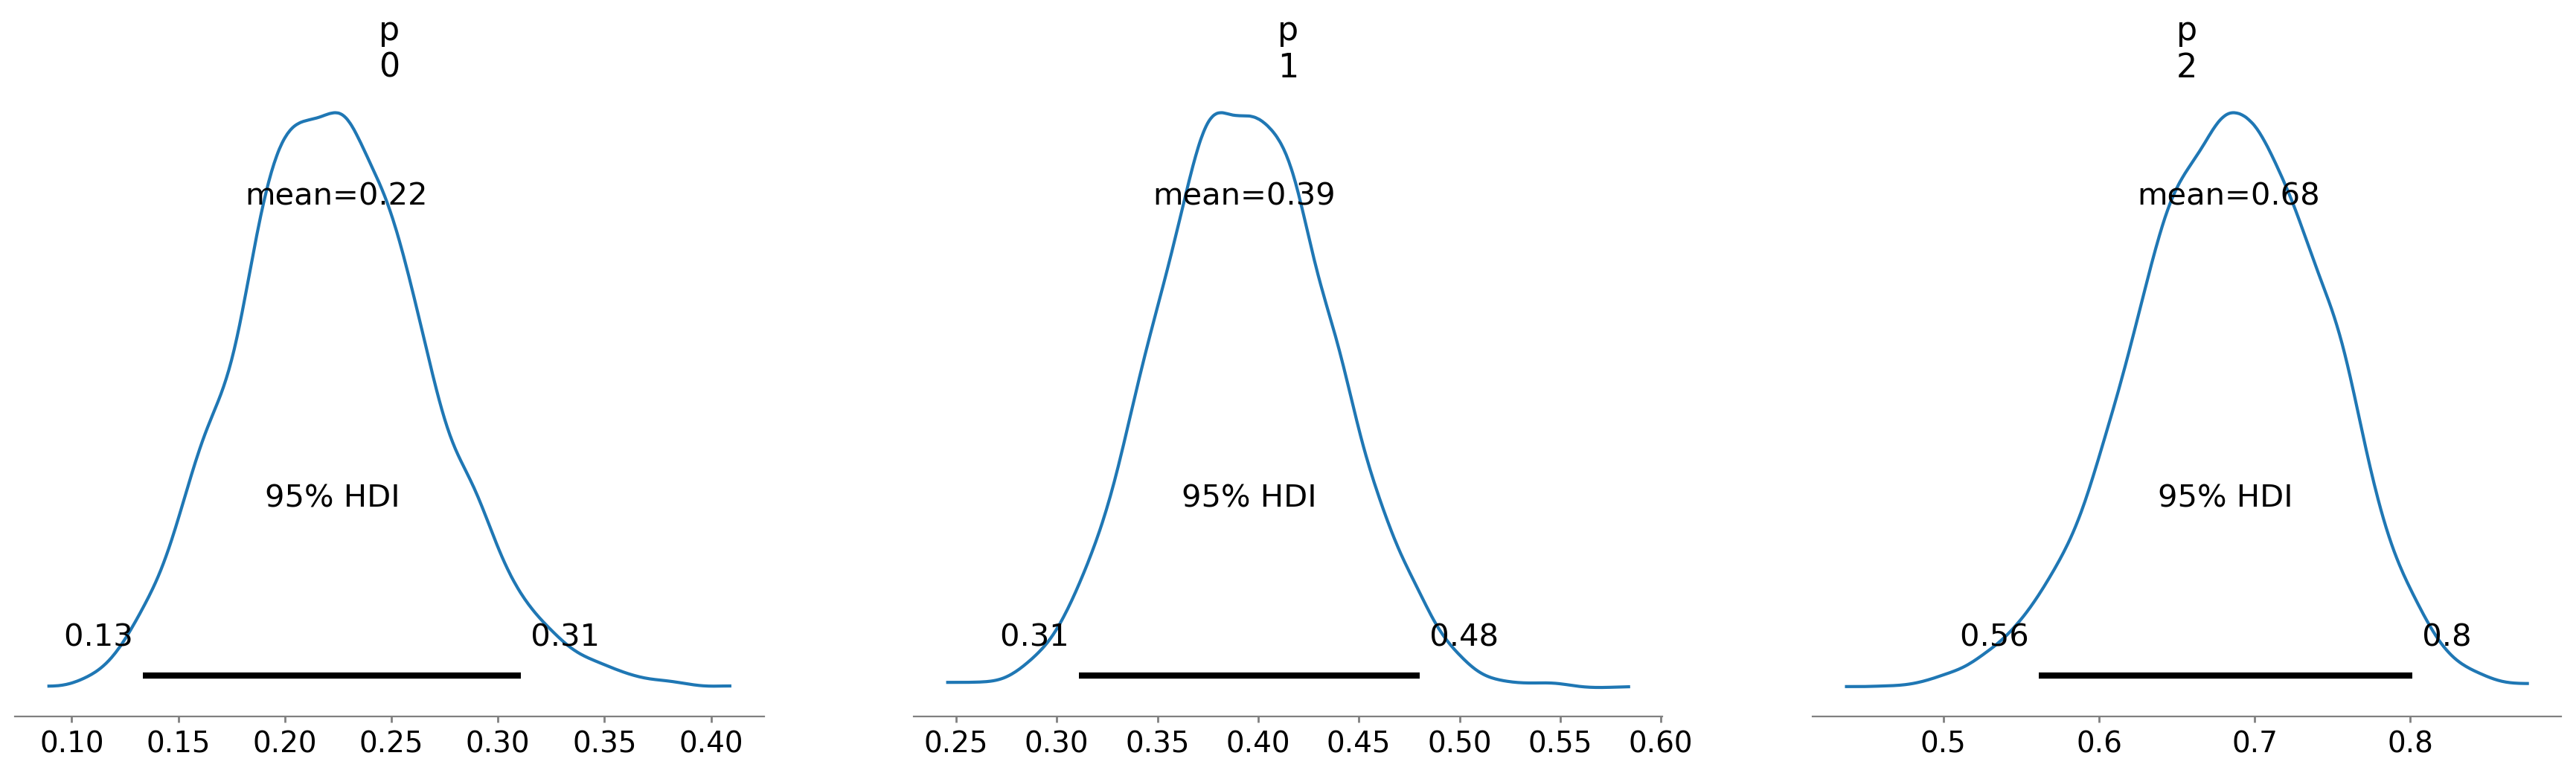

In [36]:
az.plot_posterior(idata_h, var_names=["p"], hdi_prob=0.95)
plt.show()

Teniendo los datos observados para cada campaña. El modelo nos dice lo siguiente,

* **Nivel de campañas (nivel inferior)**. Cada campaña $i$ tiene su propia tasa $p_i$. No asumimos que todas tienen el mismo valor, pero tampoco las tratamos como totalmente independientes.
* **Nivel de hiper-parámetros (nivel superior)**. Todos los $p_i$ provienen de una misma distribución Beta común, con parámetros $alpha$ y $\beta$. Esta distribución Beta compartida actúa como una especia de "población de las campañas". Las campañas entonces comparten información a través de estos hiperparámetros.
* **Hyper priors HalfNormal para $\alpha$ y $\beta$ **. Usar esta distribución permite flexibilidad al estar buscando únicamente valores positivos para estos parámetros.

Si modelaras cada campaña por separado con un Beta-Binomial independienet, cada $p_i$ se ajustaría sólo con us datos $(x_i, n_i)$. Con este modelo jerárquico, las campañas "se hablan entre sí" a través de los parámetros $\alpha$ y $\beta$. Campañas con pocos datos tienden a ser "empujadas" hacia la media global. Campañas con muchos datos pueden alejarse más de esa media, porque tienen evidencia propia fuerte.

En resumen, el modelo jerárquico regulariza las estimaciones de cada $p_i$, evitando estimaciones extremas cuando hay pocos datos y permitiendo que los datos dominen cuando son abundantes.